# Machine Learning with Financial Time Series Data on Google Cloud Platform

## Outline...

Time series are the lifeblood that circulates the body of finance and time series analysis is the heart that moves that fluid.  That's the way finance has always functioned and always will.  However, the nature of that blood, body and heart has evolved over time.  There is more data, both more sources of data (e.g. more exchanges, plus social media, plus news, etc.) and more frequent delivery of data (i.e. 10s of messages per second 10 years ago has become 100s of 1,000s of messages per second today).  More and different analysis techniques are being brought to bear.  Most of the analysis techniques are not different in the sense of being new, and have their basis in statistics, but their applicability has closely followed the amount of computing power available.  The growth in available computing power is faster than the growth in time series volumes and so it is possible to analyze time series today at scale in ways that weren't tractable previously.

This is particularly true of machine learning, especially deep learning, and these techniques hold great promise for time series.  As time series become more dense and many time series overlap, machine learning offers a way to identify the signal from the noise even when the noise can see overwhelming, and deep learning holds great potential because it is often the best fit for the almost random nature of financial time series.

This solution is accessible, non-trivial example of machine learning with financial time series on Google Cloud Platform (GCP).

The premise for our investigation is straightforward, that financial markets are increasingly global and if we follow the sun from Asia to Europe to the US and so on we can use information from an earlier timezone to our advantage in a later timezone.

In this solution, we will:

* Obtain data for a number of financial markets.
* Munge that data into a usable format and perform exploratory data analysis in order to explore and validate our premise.
* Use TensorFlow to build, train and evaluate a number of models for predicting what will happen in financial markets

All from within this notebook!  Life is sweet...

***This work is intended to illustrate the capabilities of GCP and TensorFlow for fast, interactive, iterative data analysis and machine learning.  It is not intended to offer any advice on financial markets or trading strategies.***

## Pre-Requisites...

* [Create a project](https://cloud.google.com/docs/overview/)
* Enable billing.
* [Launch Cloud Datalab for your project](https://cloud.google.com/datalab/getting-started)
* [Download a copy of this notebook from GitHub](https://github.com/corrieelston/datalab) and upload it to your Cloud Datalab notebooks.

N.B. You do not need to download and run your own copy of this notebook on Cloud Datalab to read and derive value (keep reading as you are now and enjoy!) but if you wish to make changes of your own and experiment (which is strongly encouraged) you will need to satisfy the pre-requisites above.

## The Premise...

As stated before, the premise for our investigation is straightforward, that financial markets are increasingly global and if we follow the sun from Asia to Europe to the US and so on we can use information from an earlier timezone to our advantage in a later timezone.

The table below shows a number of stock market indices from around the globe, their closing times in EST, and the delay in hours between the close that index and the close of the S&P 500 in New York (hence taking EST as a base timezone).  For example, Australian markets close for the day 15 hours before US markets close.  So, if the close of the All Ords in Australia is a useful predictor of the close of the S&P 500 for a given day we can use that information to guide our trading activity.  Continuing our example of the Australian All Ords, if this index closes up and we think that means the S&P 500 will close up as well then we should buy either stocks that compose the S&P 500 or more likely an ETF that tracks the S&P 500.  N.B. The situation is more complex in reality because there are commissions and tax to account for but as a first approximation we'll assume an index closing up indicates a gain and vice versa.

|Index|Country|Closing Time (EST)|Hours Before S&P Close|
|---|---|---|---|
|[All Ords](https://en.wikipedia.org/wiki/All_Ordinaries)|Australia|0100|15|
|[Nikkei 225](https://en.wikipedia.org/wiki/Nikkei_225)|Japan|0200|14|
|[Hang Seng](https://en.wikipedia.org/wiki/Hang_Seng_Index)|Hong Kong|0400|12|
|[DAX](https://en.wikipedia.org/wiki/DAX)|Germany|1130|4.5|
|[FTSE 100](https://en.wikipedia.org/wiki/FTSE_100_Index)|UK|1130|4.5|
|[NYSE Composite](https://en.wikipedia.org/wiki/NYSE_Composite)|US|1600|0|
|[Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average)|US|1600|0|
|[S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index)|US|1600|0|

## Setup...

First let's import necessary libraries.

In [1]:
import StringIO

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt

import gcp
import gcp.bigquery as bq

import tensorflow as tf

## Get the Data...

We'll use data from the last 5 years (approximately) - 1/1/2010-10/1/2015 - for the S&P 500 (S&P), NYSE, Dow Jones Industrial Average (DJIA), Nikkei 225 (Nikkei), Hang Seng, FTSE 100 (FTSE), DAX, All Ordinaries (AORD) indices.

This data is publicly available and has stored in BigQuery for convenience.  We'll use the built-in connector functionality in Cloud Datalab to access this data as Pandas DataFrames.

In [2]:
%%sql --module market_data_query
SELECT Date, Close FROM $market_data_table where Date < '2015-01-01 00:00:00'

In [3]:
snp = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.snp')).to_dataframe().set_index('Date')
nyse = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.nyse')).to_dataframe().set_index('Date')
djia = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.djia')).to_dataframe().set_index('Date')
nikkei = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.nikkei')).to_dataframe().set_index('Date')
hangseng = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.hangseng')).to_dataframe().set_index('Date')
ftse = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.ftse')).to_dataframe().set_index('Date')
dax = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.dax')).to_dataframe().set_index('Date')
aord = bq.Query(market_data_query, market_data_table=bq.Table('bingo-ml-1:market_data.aord')).to_dataframe().set_index('Date')

In [4]:
%%sql --module google_trends_query
select Date2 as Date, Debt, StockMarket, China, Gold, Oil from [life-is-sweet-1:market_data.google_trends] where Date2 < '2015-01-01 00:00:00'

In [5]:
google_trends = bq.Query(google_trends_query).to_dataframe().set_index('Date')

In [6]:
google_trends.describe()

,Debt,StockMarket,China,Gold,Oil
count,259.000000,259.000000,259.000000,259.000000,259.000000
mean,15.359073,13.818533,2.660232,33.764479,11.405405
std,2.942344,5.385334,0.659164,9.451761,6.344268
min,9.000000,8.000000,2.000000,22.000000,5.000000
25%,14.000000,11.000000,2.000000,29.000000,7.000000
50%,15.000000,13.000000,3.000000,32.000000,10.000000
75%,16.000000,15.000000,3.000000,36.000000,13.000000
max,28.000000,77.000000,5.000000,100.000000,52.000000


In [7]:
google_trends = google_trends.resample('D', fill_method='pad')
google_trends[:10]

,Debt,StockMarket,China,Gold,Oil
Date,,,,,
2010-01-16,23,14,4,35,13
2010-01-17,23,14,4,35,13
2010-01-18,23,14,4,35,13
2010-01-19,23,14,4,35,13
2010-01-20,23,14,4,35,13
2010-01-21,23,14,4,35,13
2010-01-22,23,14,4,35,13
2010-01-23,23,13,4,32,13
2010-01-24,23,13,4,32,13


## Munge the Data...

Munging the data is quite straightforward in the first instance.  We're interested in closing prices so for convenience we'll extract the closing prices for each of the indices into a single Pandas DataFrame, called closing_data.  Because not all of the indices have the same number of values, mainly due to bank holidays, we'll forward fill the gaps.  This simply means that if a values isn't available for day N we'll fill it with the value for day N-1 (or N-2 etc.) such that we fill it with the latest available value.

In [8]:
closing_data = pd.DataFrame()

closing_data['snp_close'] = snp['Close']
closing_data['nyse_close'] = nyse['Close']
closing_data['djia_close'] = djia['Close']
closing_data['nikkei_close'] = nikkei['Close']
closing_data['hangseng_close'] = hangseng['Close']
closing_data['ftse_close'] = ftse['Close']
closing_data['dax_close'] = dax['Close']
closing_data['aord_close'] = aord['Close']
closing_data['debt'] = google_trends['Debt']
closing_data['stockmarket'] = google_trends['StockMarket']
closing_data['china'] = google_trends['China']
closing_data['gold'] = google_trends['Gold']
closing_data['oil'] = google_trends['Oil']

# Pandas includes a very convenient function for filling gaps in the data.
closing_data = closing_data.fillna(method='ffill')

In [9]:
closing_data.ix[closing_data['debt'].isnull(), 'debt'] = 0
closing_data.ix[closing_data['stockmarket'].isnull(), 'stockmarket'] = 0
closing_data.ix[closing_data['china'].isnull(), 'china'] = 0
closing_data.ix[closing_data['gold'].isnull(), 'gold'] = 0
closing_data.ix[closing_data['oil'].isnull(), 'oil'] = 0

## What Do We Think So Far I..?

What do we think so far?

Well, so far, we've sourced five years of time series for eight financial indices, combined the pertinent data into a single data structure and harmonized the data to have the same number of entries in 20 lines of code in this notebook.  That's awesome...  Plus it took about 10 seconds to do all of that.  That's awesome and it shows how Cloud Datalab can amplify your productivity, first by giving you access to all the goodness of Python (normal practice for iPython notebooks :)), and second by giving you a host of connectors to GCP services (we just used BigQuery, you are free to experiment with Google Cloud Storage, and you can expect the number of these connectors to grow...).

## Exploratory Data Analysis...

Exploratory Data Analysis (EDA) is foundational to our work with machine learning (and any other sort of analysis).  EDA means getting to know your data, getting your fingers dirty with your data, feeling it and seeing it.  The end result is that your data is your friend and you know it like you know a friend, so when you build models you build them based on an actual, practical, physical understanding of the data and not assumptions of vaguely held notions.  You can still make assumptions of course but EDA means you will understand your assumptions and why you're making those assumptions.  EDA is cool, EDA is foundational and critically important, show love for EDA...

Let's first take a look at our data.

In [10]:
closing_data.describe()

,snp_close,nyse_close,djia_close,nikkei_close,hangseng_close,ftse_close,dax_close,aord_close,debt,stockmarket,china,gold,oil
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,1472.574681,8639.520063,13476.547605,11523.175867,21838.726002,6010.657232,7497.491539,4813.593876,15.260731,13.698728,2.641494,33.480127,11.218601
std,292.379200,1301.765601,2241.600367,2705.370388,1677.577966,525.539180,1341.122039,428.617204,3.230533,5.532922,0.696230,9.900700,6.041943
min,1022.580017,6434.810059,9686.480469,8160.009766,16250.269531,4805.799805,5072.330078,3927.600098,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1239.874969,7558.292358,11647.857666,9351.062744,20631.079590,5626.075195,6291.505127,4427.575195,14.000000,11.000000,2.000000,29.000000,7.000000
50%,1383.669983,8277.435059,12980.904785,10314.029785,22126.979493,5911.000000,7205.094971,4798.500000,15.000000,13.000000,3.000000,32.000000,10.000000
75%,1701.047486,9712.530029,15492.150146,14334.967285,23165.810547,6538.950074,8635.867187,5185.625122,16.000000,15.000000,3.000000,36.000000,13.000000
max,2090.570068,11104.719727,18053.710938,17935.640625,25317.949219,6878.500000,10087.120117,5656.899902,28.000000,77.000000,5.000000,100.000000,41.000000


We see that the various indices operate on scales differing by orders of magnitude which isn't great, it also isn't terrible it just means we'll scale our data so that - for example -  operations involving multiple indices are not unduly influenced by a single, massive index.

Now let's plot out data.

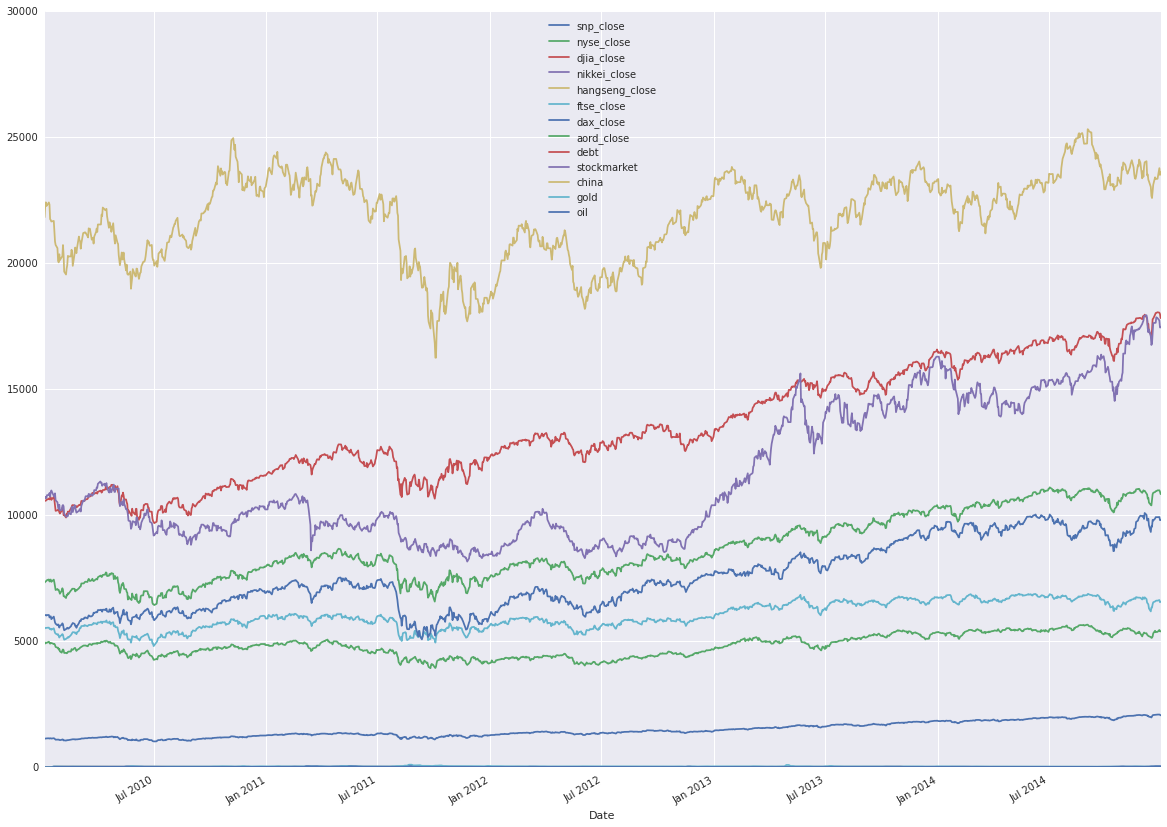

In [11]:
# N.B. A super-useful trick-ette is to assign the return value of plot to _ so that you don't get text printed before the plot itself.

_ = pd.concat([closing_data['snp_close'],
  closing_data['nyse_close'],
  closing_data['djia_close'],
  closing_data['nikkei_close'],
  closing_data['hangseng_close'],
  closing_data['ftse_close'],
  closing_data['dax_close'],
  closing_data['aord_close'],
  closing_data['debt'],
  closing_data['stockmarket'],
  closing_data['china'],
  closing_data['gold'],
  closing_data['oil']], axis=1).plot(figsize=(20, 15))

As expected the structure isn't uniformly visible for the indices so let's scale the value for each day of a given index divided by the maximum value for that index in the dataset and replot (i.e. the maximum value of all indicies will be 1).

In [12]:
closing_data['snp_close_scaled'] = closing_data['snp_close'] / max(closing_data['snp_close'])
closing_data['nyse_close_scaled'] = closing_data['nyse_close'] / max(closing_data['nyse_close'])
closing_data['djia_close_scaled'] = closing_data['djia_close'] / max(closing_data['djia_close'])
closing_data['nikkei_close_scaled'] = closing_data['nikkei_close'] / max(closing_data['nikkei_close'])
closing_data['hangseng_close_scaled'] = closing_data['hangseng_close'] / max(closing_data['hangseng_close'])
closing_data['ftse_close_scaled'] = closing_data['ftse_close'] / max(closing_data['ftse_close'])
closing_data['dax_close_scaled'] = closing_data['dax_close'] / max(closing_data['dax_close'])
closing_data['aord_close_scaled'] = closing_data['aord_close'] / max(closing_data['aord_close'])
closing_data['debt_scaled'] = closing_data['debt'] / max(closing_data['debt'])
closing_data['stockmarket_scaled'] = closing_data['stockmarket'] / max(closing_data['stockmarket'])
closing_data['china_scaled'] = closing_data['china'] / max(closing_data['china'])
closing_data['gold_scaled'] = closing_data['gold'] / max(closing_data['gold'])
closing_data['oil_scaled'] = closing_data['oil'] / max(closing_data['oil'])

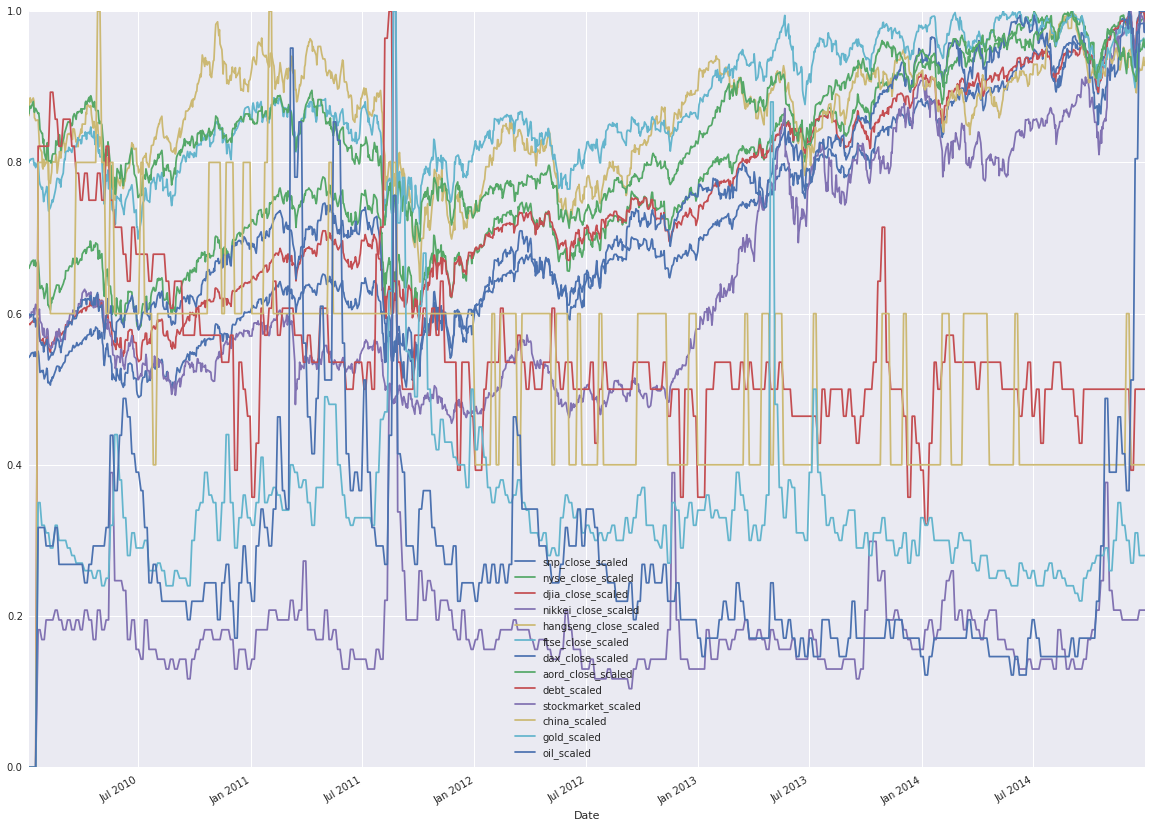

In [13]:
_ = pd.concat([closing_data['snp_close_scaled'],
  closing_data['nyse_close_scaled'],
  closing_data['djia_close_scaled'],
  closing_data['nikkei_close_scaled'],
  closing_data['hangseng_close_scaled'],
  closing_data['ftse_close_scaled'],
  closing_data['dax_close_scaled'],
  closing_data['aord_close_scaled'],
  closing_data['debt_scaled'],
  closing_data['stockmarket_scaled'],
  closing_data['china_scaled'],
  closing_data['gold_scaled'],
  closing_data['oil_scaled']], axis=1).plot(figsize=(20, 15))

Now we see that over the five year period these indices are correlated (i.e. sudden drops from economic events happened globally to all indices, general rises otherwise).  This is an encouraging start, not the complete story but a good start.  Let's carry on and plot autocorrelations for each of the indicies (correlations of the index with lagged values of the index, e.g. is yesterday indicative of today?)

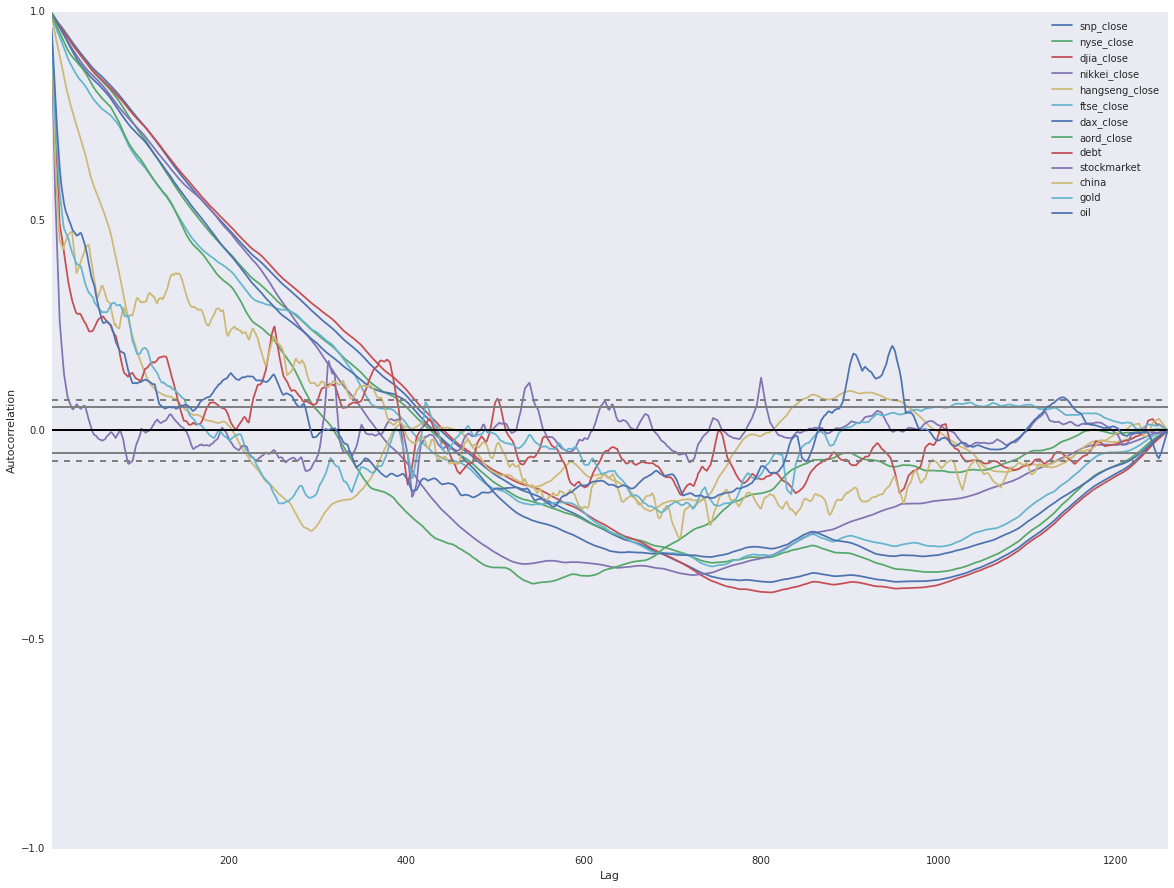

In [14]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(closing_data['snp_close'], label='snp_close')
_ = autocorrelation_plot(closing_data['nyse_close'], label='nyse_close')
_ = autocorrelation_plot(closing_data['djia_close'], label='djia_close')
_ = autocorrelation_plot(closing_data['nikkei_close'], label='nikkei_close')
_ = autocorrelation_plot(closing_data['hangseng_close'], label='hangseng_close')
_ = autocorrelation_plot(closing_data['ftse_close'], label='ftse_close')
_ = autocorrelation_plot(closing_data['dax_close'], label='dax_close')
_ = autocorrelation_plot(closing_data['aord_close'], label='aord_close')
_ = autocorrelation_plot(closing_data['debt'], label='debt')
_ = autocorrelation_plot(closing_data['stockmarket'], label='stockmarket')
_ = autocorrelation_plot(closing_data['china'], label='china')
_ = autocorrelation_plot(closing_data['gold'], label='gold')
_ = autocorrelation_plot(closing_data['oil'], label='oil')

_ = plt.legend(loc='upper right')

We see strong autocorrelations, positive for ~500 lagged days then going negative.  This tells us something we intuitively knew, if an index is rising it tends to carry on rising and vice versa.  Nice, we're getting a feel for our index data, a similar general structure and conforms to what we know about financial markets.

Next we'll look at a scatter matix (i.e. everything plotted against everything) to see how indicies are correlated with each other.

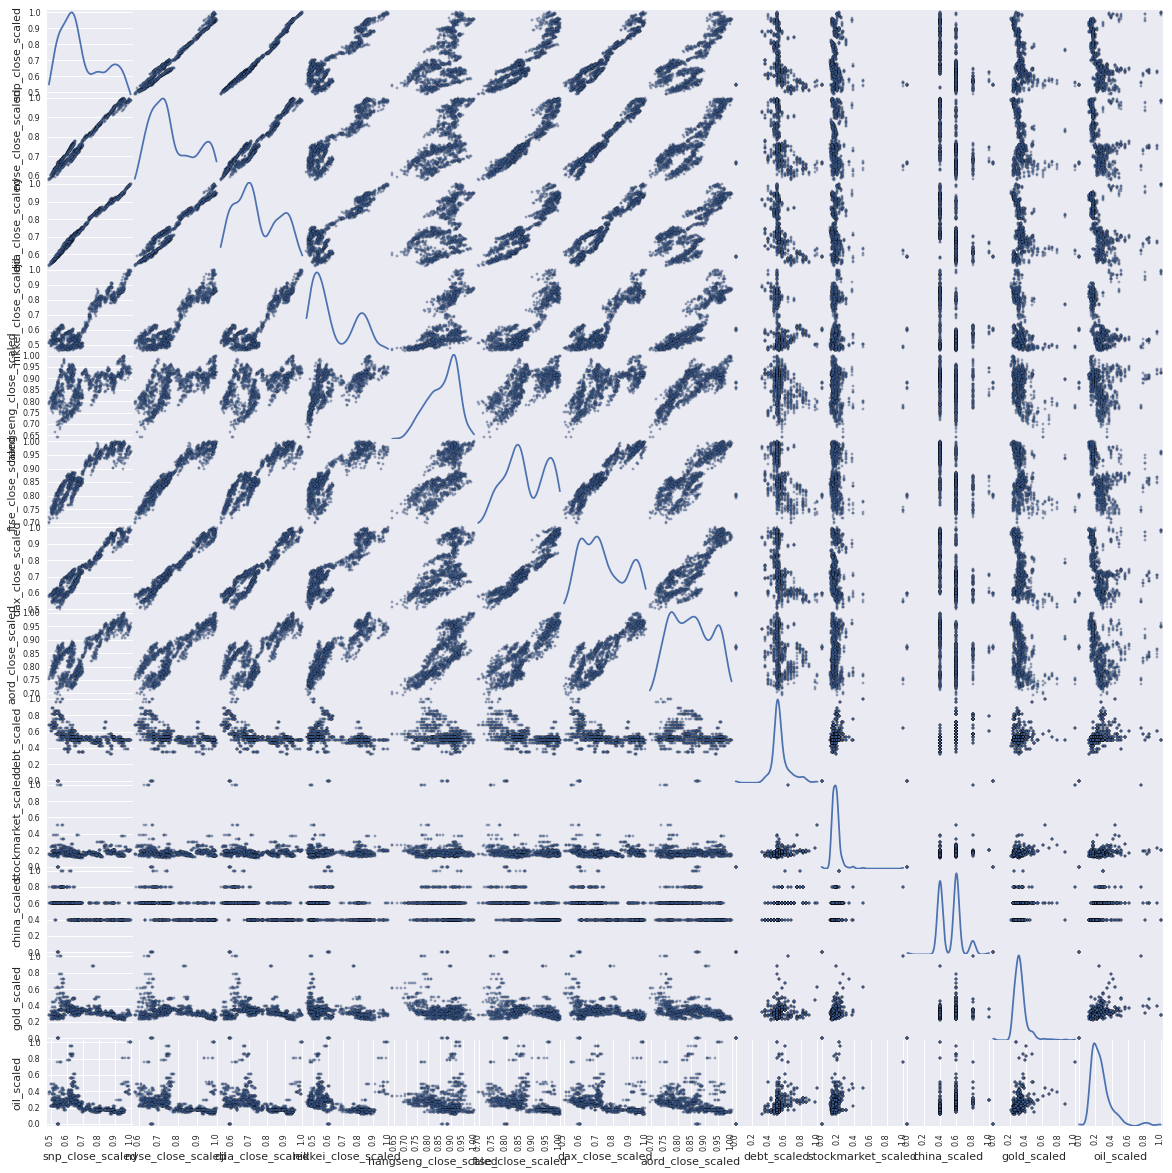

In [15]:
_ = scatter_matrix(pd.concat([closing_data['snp_close_scaled'],
  closing_data['nyse_close_scaled'],
  closing_data['djia_close_scaled'],
  closing_data['nikkei_close_scaled'],
  closing_data['hangseng_close_scaled'],
  closing_data['ftse_close_scaled'],
  closing_data['dax_close_scaled'],
  closing_data['aord_close_scaled'],
  closing_data['debt_scaled'],
  closing_data['stockmarket_scaled'],
  closing_data['china_scaled'],
  closing_data['gold_scaled'],
  closing_data['oil_scaled']], axis=1), figsize=(20, 20), diagonal='kde')

Significant correlations across the board.  Further evidence that our premise is workable and one market is influenced by another.  As an aside, the process we're following of gradual incremental experimentation and progress is spot on what we should be doing and what I'm sure you do normally.  For anyone champing at the bit for the meat to go with these potatoes, we're getting there...

The actual value of an index is not that useful to us for modeling.  It's indicative, it's useful - and we've seen that from our visualizations to date - but to really get to the meat we're looking for we need a time series that is stationary in the mean (i.e. there is no trend in the data).  There's various ways of doing that but they all essentially look the the difference between values rather than the absolute value.  In the case of market data the usual practice is to work with logged returns (the natural logaritm of the index today divided by the index yesterday).  I.e.

`ln(Vt/Vt-1)`

Where `Vt` is the value of the index on day t and `Vt-1` is the value of the index on day t-1.  There are other reasons why the log return is prefereable to the percent return (for example the log is normally distributed and additive) but they don't matter much for this work.  What matters is we get to a stationary time series.

Let's calculate the log returns and plot those.  We'll do this in a new DataFrame.

In [16]:
log_return_data = pd.DataFrame()

log_return_data['snp_log_return'] = np.log(closing_data['snp_close']/closing_data['snp_close'].shift())
log_return_data['nyse_log_return'] = np.log(closing_data['nyse_close']/closing_data['nyse_close'].shift())
log_return_data['djia_log_return'] = np.log(closing_data['djia_close']/closing_data['djia_close'].shift())
log_return_data['nikkei_log_return'] = np.log(closing_data['nikkei_close']/closing_data['nikkei_close'].shift())
log_return_data['hangseng_log_return'] = np.log(closing_data['hangseng_close']/closing_data['hangseng_close'].shift())
log_return_data['ftse_log_return'] = np.log(closing_data['ftse_close']/closing_data['ftse_close'].shift())
log_return_data['dax_log_return'] = np.log(closing_data['dax_close']/closing_data['dax_close'].shift())
log_return_data['aord_log_return'] = np.log(closing_data['aord_close']/closing_data['aord_close'].shift())
log_return_data['debt'] = closing_data['debt_scaled']
log_return_data['stockmarket'] = closing_data['stockmarket_scaled']
log_return_data['china'] = closing_data['china_scaled']
log_return_data['gold'] = closing_data['gold_scaled']
log_return_data['oil'] = closing_data['oil_scaled']

log_return_data.describe()

,snp_log_return,nyse_log_return,djia_log_return,nikkei_log_return,hangseng_log_return,ftse_log_return,dax_log_return,aord_log_return,debt,stockmarket,china,gold,oil
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.000475,0.000312,0.000415,0.000393,0.000062,0.000141,0.000384,0.000077,0.545026,0.177906,0.528299,0.334801,0.273624
std,0.010092,0.010669,0.009188,0.013693,0.011541,0.009810,0.012724,0.008916,0.115376,0.071856,0.139246,0.099007,0.147364
min,-0.068958,-0.073116,-0.057061,-0.111534,-0.058270,-0.047792,-0.064195,-0.042998,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.003877,-0.004382,-0.003589,-0.006674,-0.005762,-0.004690,-0.005602,-0.004630,0.500000,0.142857,0.400000,0.290000,0.170732
50%,0.000723,0.000725,0.000606,0.000000,0.000000,0.000229,0.000701,0.000407,0.535714,0.168831,0.600000,0.320000,0.243902
75%,0.005468,0.005791,0.005020,0.008401,0.006236,0.005502,0.006648,0.005227,0.571429,0.194805,0.600000,0.360000,0.317073
max,0.046317,0.051173,0.041533,0.055223,0.055187,0.050323,0.052104,0.034368,1.000000,1.000000,1.000000,1.000000,1.000000


Looking at our log returns we're now moving forward more rapidly.  The mean, min, max are all similar.  We could go further and center the series on zero, scale them and normalize the standard deviation but there's no need to do that at this point.  Let's move forward and iterate if necessary.

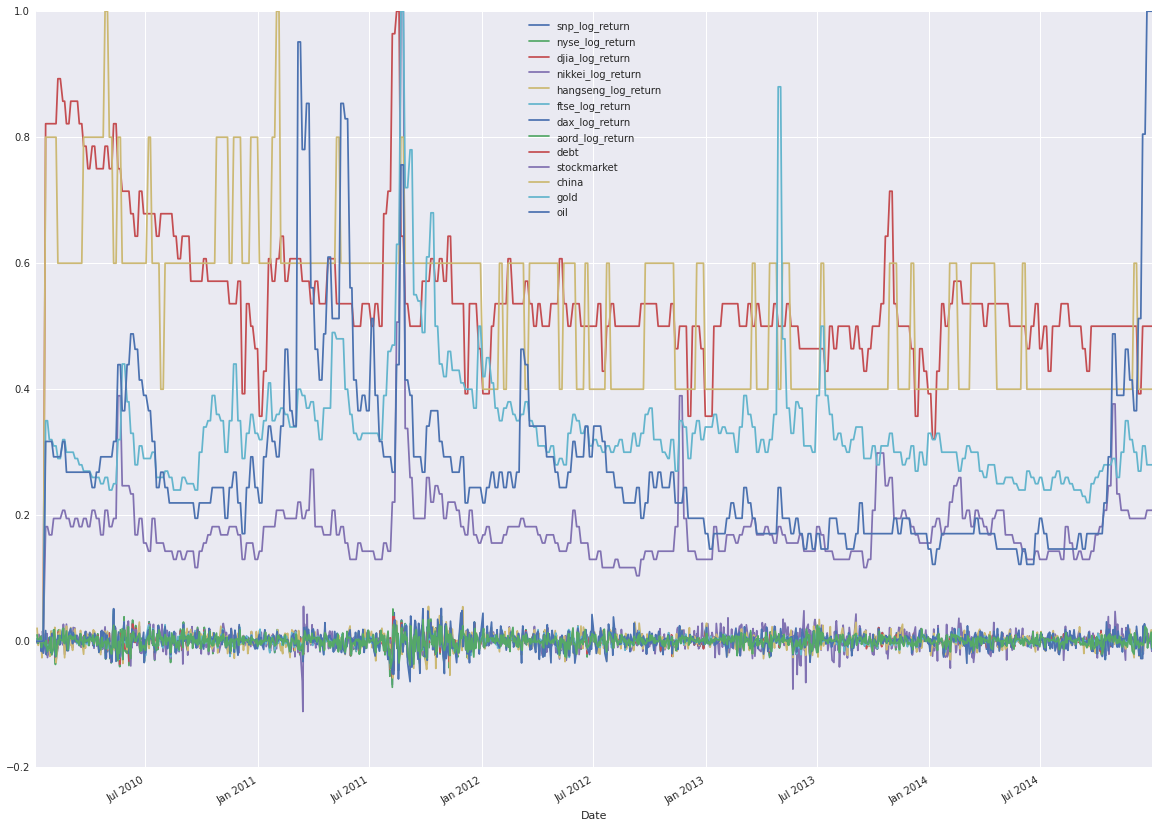

In [17]:
_ = pd.concat([log_return_data['snp_log_return'],
  log_return_data['nyse_log_return'],
  log_return_data['djia_log_return'],
  log_return_data['nikkei_log_return'],
  log_return_data['hangseng_log_return'],
  log_return_data['ftse_log_return'],
  log_return_data['dax_log_return'],
  log_return_data['aord_log_return'],
  log_return_data['debt'],
  log_return_data['stockmarket'],
  log_return_data['china'],
  log_return_data['gold'],
  log_return_data['oil']], axis=1).plot(figsize=(20, 15))

We can see from this that the log returns of our indices are similarly scaled and centered with no trend visible in the data.  Looking good, now let's look at autocorrelations.

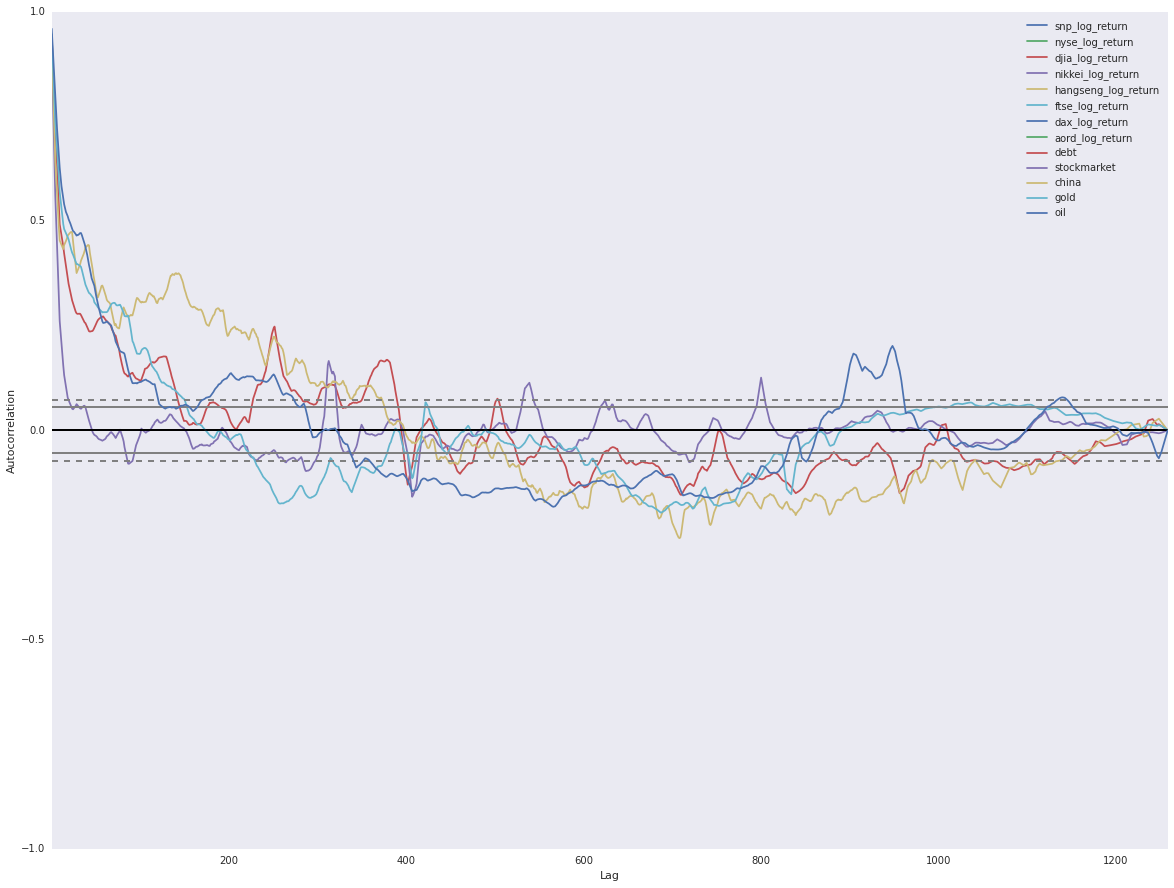

In [18]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(log_return_data['snp_log_return'], label='snp_log_return')
_ = autocorrelation_plot(log_return_data['nyse_log_return'], label='nyse_log_return')
_ = autocorrelation_plot(log_return_data['djia_log_return'], label='djia_log_return')
_ = autocorrelation_plot(log_return_data['nikkei_log_return'], label='nikkei_log_return')
_ = autocorrelation_plot(log_return_data['hangseng_log_return'], label='hangseng_log_return')
_ = autocorrelation_plot(log_return_data['ftse_log_return'], label='ftse_log_return')
_ = autocorrelation_plot(log_return_data['dax_log_return'], label='dax_log_return')
_ = autocorrelation_plot(log_return_data['aord_log_return'], label='aord_log_return')
_ = autocorrelation_plot(log_return_data['debt'], label='debt')
_ = autocorrelation_plot(log_return_data['stockmarket'], label='stockmarket')
_ = autocorrelation_plot(log_return_data['china'], label='china')
_ = autocorrelation_plot(log_return_data['gold'], label='gold')
_ = autocorrelation_plot(log_return_data['oil'], label='oil')

_ = plt.legend(loc='upper right')

No autocorrelations visible on the plot which is what we're looking for.  Individual financial markets are Markov processes, knowledge of history doesn't allow you to predict the future (if only it were that easy...).  That's great!  We have time series for our indicies that are stationary in the mean, similarly centered and scaled.  Now let's start to look for signals we can use to predict the close of the S&P 500.  Signal from the noise baby!

Let's look at a scatter plot to see how our log return indices correlate with each other.

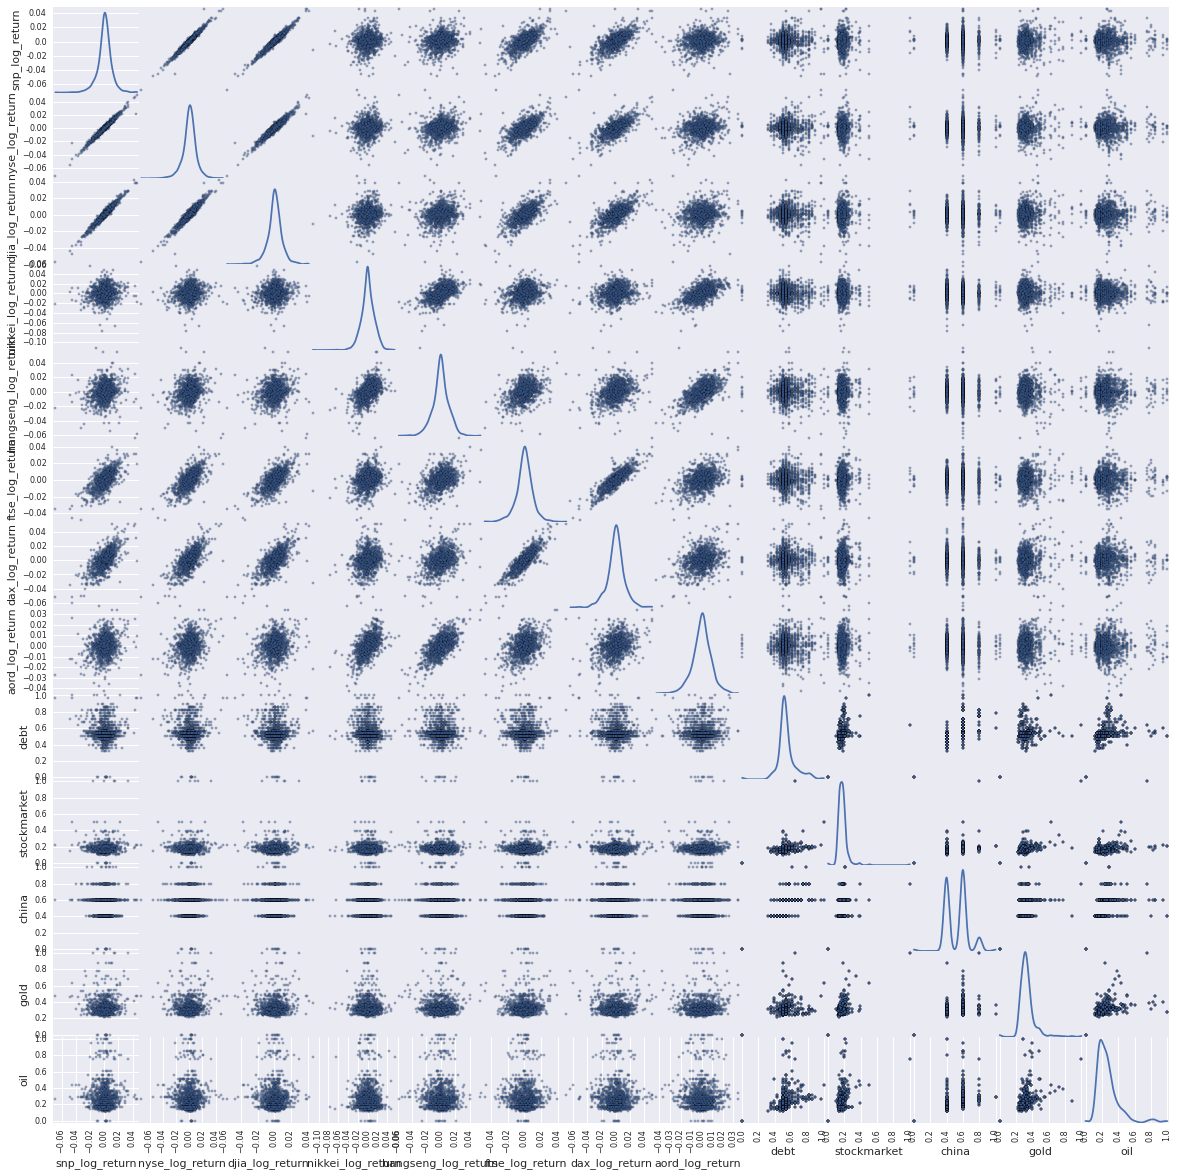

In [19]:
_ = scatter_matrix(log_return_data, figsize=(20, 20), diagonal='kde')

The story with our scatter plot above for log returns is more subtle and more interesting.  The US indices are strongly correlated which is expected.  The other indices less so, also expected, but there is structure and signal there.  We can see it, now let's move forward and start to quantify it so we can start to choose features for our model.

First let's look at how the log returns for the S&P 500 close correlate with other indices closes available on the same day.  This essentially means we assume the indices that close before the S&P 500 (non-US indices) are available and the others (US indices) are not.

In [20]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift()
tmp['djia_1'] = log_return_data['djia_log_return'].shift()
tmp['ftse_0'] = log_return_data['ftse_log_return']
tmp['dax_0'] = log_return_data['dax_log_return']
tmp['hangseng_0'] = log_return_data['hangseng_log_return']
tmp['nikkei_0'] = log_return_data['nikkei_log_return']
tmp['aord_0'] = log_return_data['aord_log_return']
tmp.corr().icol(0)

snp_0         1.000000
nyse_1       -0.049916
djia_1       -0.062820
ftse_0        0.669080
dax_0         0.677678
hangseng_0    0.190576
nikkei_0      0.126309
aord_0        0.228711
Name: snp_0, dtype: float64

Here we are directly working with our premise.  We're correlating the close of the S&P 500 with signals available before the close of the S&P 500.  Bingo!  The S&P 500 close is correlated with European indices (~0.65 for the FTSE and DAX) which is a strong correlation and Asian/Oceanian indices (~0.15-0.22) which is a significant correlation, but not with US indicies.  This is good stuff.  We have available signals from other indicies and regions for our model.

Now let's look a how the log returns for the S&P close correlate with index values from the previous day (i.e. are yesterday's values useful in predicting today's close).  Following from our premise that financial markets are Markov processes there should be little or no value in hostorical values.  Let's see...

In [21]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(2)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(2)
tmp['ftse_0'] = log_return_data['ftse_log_return'].shift()
tmp['dax_0'] = log_return_data['dax_log_return'].shift()
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift()
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift()
tmp['aord_0'] = log_return_data['aord_log_return'].shift()
tmp.corr().icol(0)

snp_0         1.000000
nyse_1        0.060003
djia_1        0.043532
ftse_0       -0.000351
dax_0        -0.010789
hangseng_0    0.034573
nikkei_0      0.018617
aord_0        0.006089
Name: snp_0, dtype: float64

We see little to no correlation in this data meaning that yesterday's values are no practical help in predicting today's close.  Let's go one step further and look at correlations between today the the day before yesterday.

In [22]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(3)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(3)
tmp['ftse_0'] = log_return_data['ftse_log_return'].shift(2)
tmp['dax_0'] = log_return_data['dax_log_return'].shift(2)
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift(2)
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift(2)
tmp['aord_0'] = log_return_data['aord_log_return'].shift(2)

tmp.corr().icol(0)

snp_0         1.000000
nyse_1       -0.069128
djia_1       -0.072130
ftse_0        0.029311
dax_0        -0.007868
hangseng_0   -0.029957
nikkei_0     -0.003737
aord_0        0.019107
Name: snp_0, dtype: float64

Again, little to no correlations.

At this point we've done a good enough job of exploratory data analysis.  We've visualized our data, got to know it, felt the quality of the fabric as it were.  We've tranformed into a form that is useful for modelling - log returns in our case - and looked at how indicies relate to each other.  We've seen that indicies from other Europe strongly correlate with US indicies, and that indicies from Asia/Oceania significantly correlate with those same indicies for a given day.  We've also seen that if we look at historical values they do not correlate with today's values.  Summing up:

* European indices from the same day are a strong predictor for the S&P 500 close.
* Asian/Oceanian indicies from the same day are a significant predictor for the S&P 500 close.
* Indicies from previous days are not good predictors for the S&P close.

## What Do We Think So Far II..?

What do we think so far?

Cloud Datalab is rocking for us.  In a few lines of code we're able to noodle our data, visualize our noodling and make decisions.  Analyze and iterate!  This is common feature of iPython but the advantage we have here is that this is a managed service, we simply click and use.  No support, no maintenance, just analysis.

## Feature Selection...

So, we've got to a point where we can see a model:
* We'll predict whether the S&P 500 close today will be higher or lower than yesterday.
* We'll use all our data sources - NYSE, DJIA, Nikkei, Hang Seng, FTSE, DAX, AORD.
* We'll use 3 sets of data points - T, T-1, T-2 - where we take the data available on day T (or T-n) i.e. today's non-US data and yesterdays US data.

Predicting whether the log return of the S&P 500 is positive or negative is a classification problem.  That is, we want to choose one option from a finite set of options, in this case positive of negative.  This is the base case of classification where we have only two values to choose from, known as binary classification (or logistic regression).

This includes the output of our exploratory data analysis, namely that indicies from other regions on a given day influence the close of the S&P 500, and it also includes other features, the same region and previous days' data.  There are two reasons for this: One, we're adding some additional features to our model for the purpose of this solution to see how things perform, and two, machine learning models are very good at finding weak signals from data.  In reality this is exactly where we'd start our modelling, not terribly small, not terribly large and see how it performs.  We'd then incrementally add, subtract and tweak features until we got to a model we're happy with.

In machine learning, as in most things, there are subtle tradeoffs happening but in general good data is better than good algorithms is better than good frameworks.  You need all three pillars but in that order of importance - data, algorithms, frameworks.

## TensorFlow...

[TensorFlow](https://tensorflow.org) is an open source software library, initiated by Google, for numerical computation using data flow graphs. TensorFlow is based on Google's machine learning expertise and is the next generation framework used internally at Google for tasks such as translation and image recognition.  It's a wonderful framework for machine learning - expressive, efficient, and easy to use.

### Feature Engineering for TensorFlow

We'll now create training and test data, together with some supporting functions for evaluating our models, for TensorFlow.

Time series data is easy from a training/test perspective. Training data should come before test data and be consecutive (i.e. you model shouldn't be trained on events from the future). That means random sampling or cross validation don't apply to time series data. Decide on a training versus test split and divide your data into training and test datasets.

In this case we'll create our features together with two additional columns, 'snp_log_return_positive' that is 1 if the log return of the S&P 500 close is positive and 0 otherwise, and 'snp_log_return_negative' that is 1 if the log return of the S&P 500 close is negative and 1 otherwise.  Now, logically we could encode this information in one column, 'snp_log_return' which is 1 if positive and 0 if negative but that's not the way TensorFlow works for classification models.  TensorFlow uses the general definition of classification (i.e. there can be many different potential values to choose from) and a form or encoding for these options called one-hot encoding.  One-hot encoding means that each choice is an entry in an array and the actual value has an entry of 1 with all other values being 0.  This is for the input of the model, where you categorically know which value is correct.  A variation of this is used for the output, each entry in the array contains the probability of the answer being that choice.  You can then choose the most likely value by choosing the highest probability, together with having a measure of the confidence you can place in that answer realtive to other answers.

we'll use 80% of our data for training and 20% for testing.

In [23]:
log_return_data['snp_log_return_positive'] = 0
log_return_data.ix[log_return_data['snp_log_return'] >= 0, 'snp_log_return_positive'] = 1
log_return_data['snp_log_return_negative'] = 0
log_return_data.ix[log_return_data['snp_log_return'] < 0, 'snp_log_return_negative'] = 1

training_test_data = pd.DataFrame(
  columns=[
    'snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2',
    'debt_0', 'debt_1', 'debt_2',
    'stockmarket_0', 'stockmarket_1', 'stockmarket_2',
    'china_0', 'china_1', 'china_2',
    'gold_0', 'gold_1', 'gold_2',
    'oil_0', 'oil_1', 'oil_2'])

for i in range(7, len(log_return_data)):
  snp_log_return_positive = log_return_data['snp_log_return_positive'].ix[i]
  snp_log_return_negative = log_return_data['snp_log_return_negative'].ix[i]
  snp_log_return_1 = log_return_data['snp_log_return'].ix[i-1]
  snp_log_return_2 = log_return_data['snp_log_return'].ix[i-2]
  snp_log_return_3 = log_return_data['snp_log_return'].ix[i-3]
  nyse_log_return_1 = log_return_data['nyse_log_return'].ix[i-1]
  nyse_log_return_2 = log_return_data['nyse_log_return'].ix[i-2]
  nyse_log_return_3 = log_return_data['nyse_log_return'].ix[i-3]
  djia_log_return_1 = log_return_data['djia_log_return'].ix[i-1]
  djia_log_return_2 = log_return_data['djia_log_return'].ix[i-2]
  djia_log_return_3 = log_return_data['djia_log_return'].ix[i-3]
  nikkei_log_return_0 = log_return_data['nikkei_log_return'].ix[i]
  nikkei_log_return_1 = log_return_data['nikkei_log_return'].ix[i-1]
  nikkei_log_return_2 = log_return_data['nikkei_log_return'].ix[i-2]
  hangseng_log_return_0 = log_return_data['hangseng_log_return'].ix[i]
  hangseng_log_return_1 = log_return_data['hangseng_log_return'].ix[i-1]
  hangseng_log_return_2 = log_return_data['hangseng_log_return'].ix[i-2]
  ftse_log_return_0 = log_return_data['ftse_log_return'].ix[i]
  ftse_log_return_1 = log_return_data['ftse_log_return'].ix[i-1]
  ftse_log_return_2 = log_return_data['ftse_log_return'].ix[i-2]
  dax_log_return_0 = log_return_data['dax_log_return'].ix[i]
  dax_log_return_1 = log_return_data['dax_log_return'].ix[i-1]
  dax_log_return_2 = log_return_data['dax_log_return'].ix[i-2]
  aord_log_return_0 = log_return_data['aord_log_return'].ix[i]
  aord_log_return_1 = log_return_data['aord_log_return'].ix[i-1]
  aord_log_return_2 = log_return_data['aord_log_return'].ix[i-2]
  debt_0 = log_return_data['debt'].ix[i]
  debt_1 = log_return_data['debt'].ix[i-1]
  debt_2 = log_return_data['debt'].ix[i-2]
  stockmarket_0 = log_return_data['stockmarket'].ix[i]
  stockmarket_1 = log_return_data['stockmarket'].ix[i-1]
  stockmarket_2 = log_return_data['stockmarket'].ix[i-2]
  china_0 = log_return_data['china'].ix[i]
  china_1 = log_return_data['china'].ix[i-1]
  china_2 = log_return_data['china'].ix[i-2]
  gold_0 = log_return_data['gold'].ix[i]
  gold_1 = log_return_data['gold'].ix[i-1]
  gold_2 = log_return_data['gold'].ix[i-2]
  oil_0 = log_return_data['oil'].ix[i]
  oil_1 = log_return_data['oil'].ix[i-1]
  oil_2 = log_return_data['oil'].ix[i-2]
  training_test_data = training_test_data.append(
    {'snp_log_return_positive':snp_log_return_positive,
    'snp_log_return_negative':snp_log_return_negative,
    'snp_log_return_1':snp_log_return_1,
    'snp_log_return_2':snp_log_return_2,
    'snp_log_return_3':snp_log_return_3,
    'nyse_log_return_1':nyse_log_return_1,
    'nyse_log_return_2':nyse_log_return_2,
    'nyse_log_return_3':nyse_log_return_3,
    'djia_log_return_1':djia_log_return_1,
    'djia_log_return_2':djia_log_return_2,
    'djia_log_return_3':djia_log_return_3,
    'nikkei_log_return_0':nikkei_log_return_0,
    'nikkei_log_return_1':nikkei_log_return_1,
    'nikkei_log_return_2':nikkei_log_return_2,
    'hangseng_log_return_0':hangseng_log_return_0,
    'hangseng_log_return_1':hangseng_log_return_1,
    'hangseng_log_return_2':hangseng_log_return_2,
    'ftse_log_return_0':ftse_log_return_0,
    'ftse_log_return_1':ftse_log_return_1,
    'ftse_log_return_2':ftse_log_return_2,
    'dax_log_return_0':dax_log_return_0,
    'dax_log_return_1':dax_log_return_1,
    'dax_log_return_2':dax_log_return_2,
    'aord_log_return_0':aord_log_return_0,
    'aord_log_return_1':aord_log_return_1,
    'aord_log_return_2':aord_log_return_2,
    'debt_0':debt_0,
    'debt_1':debt_1,
    'debt_2':debt_2,
    'stockmarket_0':stockmarket_0,
    'stockmarket_1':stockmarket_1,
    'stockmarket_2':stockmarket_2,
    'china_0':china_0,
    'china_1':china_1,
    'china_2':china_2,
    'gold_0':gold_0,
    'gold_1':gold_1,
    'gold_2':gold_2,
    'oil_0':oil_0,
    'oil_1':oil_1,
    'oil_2':oil_2},
    ignore_index=True)
  
training_test_data.describe()

,snp_log_return_positive,snp_log_return_negative,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,...,stockmarket_2,china_0,china_1,china_2,gold_0,gold_1,gold_2,oil_0,oil_1,oil_2
count,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,...,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000
mean,0.558753,0.441247,0.000476,0.000481,0.000483,0.000307,0.000313,0.000316,0.000418,0.000424,...,0.178569,0.531255,0.530935,0.530616,0.336675,0.336451,0.336227,0.275155,0.274356,0.273557
std,0.496735,0.496735,0.010110,0.010109,0.010109,0.010690,0.010689,0.010690,0.009205,0.009205,...,0.071160,0.133889,0.134678,0.135462,0.096052,0.096510,0.096964,0.146343,0.145106,0.143855
min,0.000000,0.000000,-0.068958,-0.068958,-0.068958,-0.073116,-0.073116,-0.073116,-0.057061,-0.057061,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-0.003884,-0.003871,-0.003871,-0.004388,-0.004379,-0.004379,-0.003601,-0.003601,...,0.142857,0.400000,0.400000,0.400000,0.290000,0.290000,0.290000,0.170732,0.170732,0.170732
50%,1.000000,0.000000,0.000720,0.000723,0.000723,0.000695,0.000705,0.000725,0.000606,0.000628,...,0.168831,0.600000,0.600000,0.600000,0.320000,0.320000,0.320000,0.243902,0.243902,0.243902
75%,1.000000,1.000000,0.005483,0.005483,0.005483,0.005840,0.005840,0.005840,0.005024,0.005024,...,0.194805,0.600000,0.600000,0.600000,0.360000,0.360000,0.360000,0.317073,0.317073,0.317073
max,1.000000,1.000000,0.046317,0.046317,0.046317,0.051173,0.051173,0.051173,0.041533,0.041533,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
from sklearn.preprocessing import StandardScaler

training_test_data2 = StandardScaler().fit_transform(training_test_data)

In [25]:
training_test_data3 = pd.DataFrame(training_test_data2, 
  columns=[
    'snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2',
    'debt_0', 'debt_1', 'debt_2',
    'stockmarket_0', 'stockmarket_1', 'stockmarket_2',
    'china_0', 'china_1', 'china_2',
    'gold_0', 'gold_1', 'gold_2',
    'oil_0', 'oil_1', 'oil_2'])

In [26]:
training_test_data.describe()

,snp_log_return_positive,snp_log_return_negative,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,...,stockmarket_2,china_0,china_1,china_2,gold_0,gold_1,gold_2,oil_0,oil_1,oil_2
count,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,...,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000
mean,0.558753,0.441247,0.000476,0.000481,0.000483,0.000307,0.000313,0.000316,0.000418,0.000424,...,0.178569,0.531255,0.530935,0.530616,0.336675,0.336451,0.336227,0.275155,0.274356,0.273557
std,0.496735,0.496735,0.010110,0.010109,0.010109,0.010690,0.010689,0.010690,0.009205,0.009205,...,0.071160,0.133889,0.134678,0.135462,0.096052,0.096510,0.096964,0.146343,0.145106,0.143855
min,0.000000,0.000000,-0.068958,-0.068958,-0.068958,-0.073116,-0.073116,-0.073116,-0.057061,-0.057061,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-0.003884,-0.003871,-0.003871,-0.004388,-0.004379,-0.004379,-0.003601,-0.003601,...,0.142857,0.400000,0.400000,0.400000,0.290000,0.290000,0.290000,0.170732,0.170732,0.170732
50%,1.000000,0.000000,0.000720,0.000723,0.000723,0.000695,0.000705,0.000725,0.000606,0.000628,...,0.168831,0.600000,0.600000,0.600000,0.320000,0.320000,0.320000,0.243902,0.243902,0.243902
75%,1.000000,1.000000,0.005483,0.005483,0.005483,0.005840,0.005840,0.005840,0.005024,0.005024,...,0.194805,0.600000,0.600000,0.600000,0.360000,0.360000,0.360000,0.317073,0.317073,0.317073
max,1.000000,1.000000,0.046317,0.046317,0.046317,0.051173,0.051173,0.051173,0.041533,0.041533,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
training_test_data3['snp_log_return_positive'] = training_test_data['snp_log_return_positive']
training_test_data3['snp_log_return_negative'] = training_test_data['snp_log_return_negative']
training_test_data3.describe()

,snp_log_return_positive,snp_log_return_negative,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,...,stockmarket_2,china_0,china_1,china_2,gold_0,gold_1,gold_2,oil_0,oil_1,oil_2
count,1251.000000,1251.000000,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,...,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1251.000000,1.251000e+03,1.251000e+03
mean,0.558753,0.441247,7.099748e-18,5.679798e-18,8.519697e-18,9.939647e-18,-7.099748e-18,-2.839899e-18,-1.135960e-17,-7.099748e-18,...,3.407879e-17,5.452606e-16,7.724525e-16,1.363152e-16,2.044727e-16,-2.499111e-16,-2.271919e-16,0.000000,9.087677e-17,-1.817535e-16
std,0.496735,0.496735,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,...,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400,1.000400e+00,1.000400e+00
min,0.000000,0.000000,-6.870585e+00,-6.871846e+00,-6.871855e+00,-6.871323e+00,-6.872421e+00,-6.872350e+00,-6.246984e+00,-6.247537e+00,...,-2.510402e+00,-3.969454e+00,-3.943825e+00,-3.918648e+00,-3.506518e+00,-3.487583e+00,-3.468921e+00,-1.880961,-1.891479e+00,-1.902377e+00
25%,0.000000,0.000000,-4.314330e-01,-4.306806e-01,-4.308307e-01,-4.393200e-01,-4.391943e-01,-4.394701e-01,-4.367957e-01,-4.374296e-01,...,-5.020513e-01,-9.807168e-01,-9.725963e-01,-9.646084e-01,-4.861237e-01,-4.815002e-01,-4.769334e-01,-0.713840,-7.144124e-01,-7.150692e-01
50%,1.000000,0.000000,2.411649e-02,2.389085e-02,2.373084e-02,3.634814e-02,3.663246e-02,3.821741e-02,2.044700e-02,2.219504e-02,...,-1.368965e-01,5.136519e-01,5.130178e-01,5.124113e-01,-1.736691e-01,-1.705261e-01,-1.674174e-01,-0.213646,-2.099552e-01,-2.062230e-01
75%,1.000000,1.000000,4.954213e-01,4.949485e-01,4.947782e-01,5.178483e-01,5.172708e-01,5.169435e-01,5.005813e-01,4.999343e-01,...,2.282582e-01,5.136519e-01,5.130178e-01,5.124113e-01,2.429370e-01,2.441059e-01,2.452706e-01,0.286549,2.945019e-01,3.026232e-01
max,1.000000,1.000000,4.536056e+00,4.536015e+00,4.535756e+00,4.760295e+00,4.760016e+00,4.759460e+00,4.468570e+00,4.467868e+00,...,1.154806e+01,3.502389e+00,3.484246e+00,3.466451e+00,6.908635e+00,6.878219e+00,6.848278e+00,4.955032,5.002768e+00,5.051854e+00


Now let's create our training and test data.

In [28]:
predictors_tf = training_test_data3[training_test_data.columns[2:]]

classes_tf = training_test_data3[training_test_data.columns[:2]]

training_set_size = int(len(training_test_data3) * 0.8)
test_set_size = len(training_test_data3) - training_set_size

training_predictors_tf = predictors_tf[:training_set_size]
training_classes_tf = classes_tf[:training_set_size]
test_predictors_tf = predictors_tf[training_set_size:]
test_classes_tf = classes_tf[training_set_size:]

training_predictors_tf.describe()

,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,djia_log_return_3,nikkei_log_return_0,...,stockmarket_2,china_0,china_1,china_2,gold_0,gold_1,gold_2,oil_0,oil_1,oil_2
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.000121,-0.000623,-0.000480,0.002530,0.001832,0.001887,0.002544,0.001897,0.001675,0.001900,...,-0.008910,0.172936,0.171327,0.169743,0.165865,0.163978,0.162114,0.068631,0.073718,0.078900
std,1.061565,1.061630,1.061632,1.070924,1.070975,1.070979,1.055232,1.055215,1.055216,1.019047,...,1.075322,1.007420,1.009301,1.011133,1.045845,1.047262,1.048644,0.914517,0.923908,0.933556
min,-6.870585,-6.871846,-6.871855,-6.871323,-6.872421,-6.872350,-6.246984,-6.247537,-6.247741,-8.160536,...,-2.510402,-3.969454,-3.943825,-3.918648,-3.506518,-3.487583,-3.468921,-1.880961,-1.891479,-1.902377
25%,-0.448069,-0.448642,-0.448792,-0.456766,-0.457412,-0.457687,-0.471113,-0.471746,-0.471916,-0.538806,...,-0.502051,-0.980717,-0.972596,-0.964608,-0.381972,-0.377842,-0.373761,-0.547109,-0.546260,-0.545454
50%,0.022670,0.022147,0.023582,0.040641,0.040030,0.044106,0.014979,0.014338,0.014171,-0.027544,...,-0.136897,0.513652,0.513018,0.512411,-0.069518,-0.066868,-0.064245,-0.213646,-0.209955,-0.206223
75%,0.518546,0.518076,0.517905,0.568194,0.567620,0.567290,0.520252,0.519605,0.519441,0.620581,...,0.228258,0.513652,0.513018,0.512411,0.347089,0.347764,0.348443,0.286549,0.294502,0.302623
max,4.536056,4.536015,4.535756,4.760295,4.760016,4.759460,4.468570,4.467868,4.467727,3.999283,...,11.548056,3.502389,3.484246,3.466451,6.908635,6.878219,6.848278,4.621569,4.666464,4.712624


In [29]:
test_predictors_tf.describe()

,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,djia_log_return_3,nikkei_log_return_0,...,stockmarket_2,china_0,china_1,china_2,gold_0,gold_1,gold_2,oil_0,oil_1,oil_2
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,...,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,-0.000483,0.002482,0.001912,-0.010081,-0.007297,-0.007519,-0.010137,-0.007556,-0.006672,-0.007570,...,0.035497,-0.688987,-0.682576,-0.676266,-0.660816,-0.653300,-0.645872,-0.273430,-0.293696,-0.314344
std,0.707691,0.707295,0.707289,0.648807,0.648517,0.648484,0.744489,0.744628,0.744632,0.924261,...,0.617880,0.593505,0.590028,0.586615,0.291093,0.292053,0.292980,1.252230,1.218461,1.182063
min,-2.332524,-2.333299,-2.333407,-2.194674,-2.195443,-2.195624,-2.326410,-2.327018,-2.327198,-3.138919,...,-0.684629,-0.980717,-0.972596,-0.964608,-1.215184,-1.207106,-1.199137,-1.047303,-1.050717,-1.054300
25%,-0.299208,-0.298027,-0.298180,-0.327692,-0.326652,-0.326934,-0.327104,-0.324544,-0.324713,-0.439785,...,-0.502051,-0.980717,-0.972596,-0.964608,-0.902730,-0.896132,-0.889621,-0.880572,-0.882565,-0.884685
50%,0.024898,0.025120,0.024215,0.027326,0.031008,0.030707,0.034751,0.034960,0.040311,-0.027544,...,0.045681,-0.980717,-0.972596,-0.964608,-0.694427,-0.688816,-0.683277,-0.713840,-0.714412,-0.715069
75%,0.426585,0.426105,0.425936,0.390609,0.390023,0.389702,0.421938,0.432983,0.432818,0.450774,...,0.410836,-0.980717,-0.972596,-0.964608,-0.381972,-0.377842,-0.373761,-0.547109,-0.546260,-0.630262
max,2.301145,2.300865,2.300656,1.963218,1.962743,1.962338,2.561024,2.560348,2.560196,3.408791,...,2.784342,0.513652,0.513018,0.512411,0.138785,0.140448,0.142099,4.955032,5.002768,5.051854


We'll also define some metrics here to evaluate our models.

* [Precision](https://en.wikipedia.org/wiki/Precision_and_recall#Precision) - the ability of the classifier not to label as positive a sample that is negative.
* [Recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) - the ability of the classifier to find all the positive samples.
* [F1 Score](https://en.wikipedia.org/wiki/F1_score) - This is a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
* Accuracy - the percentage correctly predicted in the test data.

In [30]:
def tf_confusion_metrics(model, actual_classes, session, feed_dict):
  predictions = tf.argmax(model, 1)
  actuals = tf.argmax(actual_classes, 1)

  ones_like_actuals = tf.ones_like(actuals)
  zeros_like_actuals = tf.zeros_like(actuals)
  ones_like_predictions = tf.ones_like(predictions)
  zeros_like_predictions = tf.zeros_like(predictions)

  tp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  tn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  fp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  fn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  tp, tn, fp, fn = \
    session.run(
      [tp_op, tn_op, fp_op, fn_op], 
      feed_dict
    )

  tpr = float(tp)/(float(tp) + float(fn))
  fpr = float(fp)/(float(tp) + float(fn))

  accuracy = (float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn))

  recall = tpr
  precision = float(tp)/(float(tp) + float(fp))
  
  f1_score = (2 * (precision * recall)) / (precision + recall)
  
  print 'Precision = ', precision
  print 'Recall = ', recall
  print 'F1 Score = ', f1_score
  print 'Accuracy = ', accuracy

### Binary Classification with TensorFlow

We'll use an interactive session, a convenience function provided by TensorFlow that works wonderfully with interactive environments like Datalab.  An interactive session allows you to interleave operations that build your graph with operations that execute your graph, making it easy for you to iterate and experiment.

Now let's get some tensors flowing...  The model is binary classification expressed in TensorFlow.

In [31]:
sess = tf.Session()

# Define variables for the number of predictors and number of classes to remove magic numbers from our code.
num_predictors = len(training_predictors_tf.columns) # 24 in the default case
num_classes = len(training_classes_tf.columns) # 2 in the default case

# Define placeholders for the data we feed into the process - feature data and actual classes.
feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, num_classes])

# Define a matrix of weights and initialize it with some small random values.
weights = tf.Variable(tf.truncated_normal([num_predictors, num_classes], stddev=0.0001))
biases = tf.Variable(tf.ones([num_classes]))

# Define our model...
# Here we take a softmax regression of the product of our feature data and weights.
model = tf.nn.softmax(tf.matmul(feature_data, weights) + biases)

# Define a cost function (we're using the cross entropy).
cost = -tf.reduce_sum(actual_classes*tf.log(model + 1e-9))

# Define a training step...
# Here we use gradient descent with a learning rate of 0.01 using the cost function we just defined.
training_step = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cost)

init = tf.initialize_all_variables()
sess.run(init)

We'll train our model in the following snippet.  The approach of TensorFlow to executing graph operations is particularly sweet.  It allows fine-grained control over the process, any operation provided to the session as part of the run operation will be executed and the results return (a list of multiple operations can be provided).

We'll train our model over 30,000 iterations using the full dataset each time (it isn't overly large).  Every thousandth iteration we'll assess the accuracy of the model on the training data to assess progress.

In [32]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

for i in range(1, 30001):
  sess.run(
    training_step, 
    feed_dict={
      feature_data: training_predictors_tf.values, 
      actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    }
  )
  if i%5000 == 0:
    print i, sess.run(
      accuracy,
      feed_dict={
        feature_data: training_predictors_tf.values, 
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
      }
    )

5000 0.71
10000 0.726
15000 0.731
20000 0.748
25000 0.762
30000 0.771


An accuracy of 65% on our training data is OK, certainly better than random.

In [33]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess, feed_dict)

Precision =  0.659793814433
Recall =  0.598130841121
F1 Score =  0.627450980392
Accuracy =  0.697211155378


The metrics for this most simple of TensorFlow models are relatively staid, an F1 Score of 0.36 is not going to blow any light bulbs in the room.  That's partly because of its simplicity and partly because we haven't tuned it, selection of hyperparameters is very important in machine learning modelling.

### Feed Forward Neural Net with Two Hidden Layer in TensorFlow

We'll now build a feed forward neural net proper with two hidden layers.

In [34]:
sess1 = tf.Session()

num_predictors = len(training_predictors_tf.columns)
num_classes = len(training_classes_tf.columns)
keep_proba = 0.33

feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, 2])

weights1 = tf.Variable(tf.truncated_normal([num_predictors, 50], stddev=0.0001))
biases1 = tf.Variable(tf.ones([50]))

weights2 = tf.Variable(tf.truncated_normal([50, 25], stddev=0.0001))
biases2 = tf.Variable(tf.ones([25]))
                     
weights3 = tf.Variable(tf.truncated_normal([25, num_classes], stddev=0.0001))
biases3 = tf.Variable(tf.ones([num_classes]))

hidden_layer_1 = tf.nn.relu(tf.matmul(feature_data, weights1) + biases1)
hidden_layer_1 = tf.nn.dropout(hidden_layer_1, keep_proba)
hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1, weights2) + biases2)
hidden_layer_2 = tf.nn.dropout(hidden_layer_2, keep_proba)
model = tf.nn.softmax(tf.matmul(hidden_layer_2, weights3) + biases3)

cost = -tf.reduce_sum(actual_classes*tf.log(model + 1e-9))

train_op1 = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cost)

init = tf.initialize_all_variables()
sess1.run(init)

Again, we'll train our model over 30,000 iterations using the full dataset each time (it isn't overly large).  Every thousandth iteration we'll assess the accuracy of the model on the training data to assess progress.

In [35]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

for i in range(1, 50001):
  sess1.run(
    train_op1, 
    feed_dict={
      feature_data: training_predictors_tf.values, 
      actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    }
  )
  if i%5000 == 0:
    print i, sess1.run(
      accuracy,
      feed_dict={
        feature_data: training_predictors_tf.values, 
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
      }
    )

5000 0.555
10000 0.578
15000 0.647
20000 0.673
25000 0.696
30000 0.729
35000 0.728
40000 0.748
45000 0.743
50000 0.749


A significant improvement in accuracy with our training data shows that the hidden layers are adding additional capacity for learning to our model.

Looking at precision, recall and accuracy below we see a measurable improvement in performance but certainly not a step function.  This shows - for me - that we're likely reaching the limits of our relatively simple feature set.

In [36]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess1, feed_dict)

Precision =  0.657407407407
Recall =  0.663551401869
F1 Score =  0.660465116279
Accuracy =  0.709163346614


In [54]:
def data_iterator(data, classes, num_steps):
  
  raw_data = np.array(data, dtype=np.float32)
  raw_classes = np.array(classes, dtype=np.float32)

  raw_data_size = len(raw_data)
  num_iterations = raw_data_size/num_steps
  
  print raw_data_size, num_iterations, num_steps, num_iterations*num_steps

  for i in range(num_iterations):
    yield (
      raw_data[i*num_steps:(i*num_steps)+num_steps], 
      raw_classes[i*num_steps:(i*num_steps)+num_steps]
    )
    
'''for step, (current_data, current_classes) in enumerate(data_iterator(training_predictors_tf.values, training_classes_tf.values, 20)):
  print step, current_classes.shape'''

'for step, (current_data, current_classes) in enumerate(data_iterator(training_predictors_tf.values, training_classes_tf.values, 20)):\n  print step, current_classes.shape'

In [55]:
from tensorflow.models.rnn import rnn, rnn_cell

with tf.Graph().as_default(), tf.Session() as sess2:
  
  initializer = tf.random_uniform_initializer(-0.1, 0.1)
  
  with tf.variable_scope("model", reuse=None, initializer=initializer):

    num_input = 39
    num_classes = 2
    num_hidden = 24
    num_steps = 10
    num_layers = 1

    feature_data = tf.placeholder(tf.float32, [None, num_input])
    actual_classes = tf.placeholder(tf.float32, [None, num_classes])

    weights_hidden = tf.Variable(tf.truncated_normal([num_input, num_hidden], stddev=0.0001))
    biases_hidden = tf.Variable(tf.ones([num_hidden]))

    weights3 = tf.Variable(tf.truncated_normal([num_hidden, num_classes], stddev=0.0001))
    biases3 = tf.Variable(tf.ones([num_classes]))

    hidden_layer = tf.matmul(feature_data, weights_hidden) + biases_hidden
    feature_data_list = tf.split(0, num_steps, feature_data)

    cell = rnn_cell.BasicLSTMCell(num_hidden, forget_bias=1.0)
    cell = rnn_cell.DropoutWrapper(cell, output_keep_prob=0.33)
    cell = rnn_cell.MultiRNNCell([cell] * num_layers)
  
    initial_state = cell.zero_state(1, tf.float32)
    outputs, states = rnn.rnn(cell, feature_data_list, initial_state=initial_state)

    output = tf.reshape(tf.concat(1, outputs), [-1, num_hidden])
    model = tf.matmul(output, weights3) + biases3

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(model, actual_classes))

    train_op1 = tf.train.AdamOptimizer(learning_rate=0.0003).minimize(cost)

    init = tf.initialize_all_variables()
    sess2.run(init)
    
    correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, np.float32))

    for i in range(5):
      
      for step, (current_data, current_classes) in enumerate(data_iterator(training_predictors_tf.values, training_classes_tf.values, 10)):     
        
        _ = sess2.run(
          train_op1, 
          {
            feature_data: current_data, 
            actual_classes: current_classes
          }
        )
        
      loop_accuracy = sess2.run(
        accuracy,
        {
          feature_data: current_data, 
          actual_classes: current_classes
        }
      )
      print i, loop_accuracy
        
    correct_preds = []
    
    for step, (current_data, current_classes) in enumerate(data_iterator(test_predictors_tf.values, test_classes_tf.values, 1)):     

      loop_accuracy, loop_correct_preds = sess2.run(
        [accuracy, correct_prediction], 
        {
          feature_data: current_data, 
          actual_classes: current_classes
        }
      )
      
      print step, loop_accuracy
      
      correct_preds.extend(loop_correct_preds)

1000 100 10 1000
0 0.7
1000 100 10 1000
1 0.6
1000 100 10 1000
2 0.7
1000 100 10 1000
3 0.6
1000 100 10 1000
4 0.6
251 251 1 251


InvalidArgumentError: Number of ways to split should evenly divide the split dimension, but got split_dim 0 (size = 1) and num_split 10
	 [[Node: model/split = Split[T=DT_FLOAT, num_split=10, _device="/job:localhost/replica:0/task:0/cpu:0"](model/split/split_dim, _recv_model/Placeholder_0)]]
Caused by op u'model/split', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 389, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 465, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 362, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-05de70c9066d>", line 25, in <module>
    feature_data_list = tf.split(0, num_steps, feature_data)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/array_ops.py", line 418, in split
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 761, in _split
    num_split=num_split, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/op_def_library.py", line 633, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1710, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 988, in __init__
    self._traceback = _extract_stack()


In [41]:
tmp1 = np.array(correct_preds)
tmp2 = tmp1.sum()
tmp3 = len(tmp1)
print tmp2, tmp3
print float(tmp2)/float(tmp3)

165 250
0.66


## What Do We Think At The End Of The Day..?

What do we think at the end of the day?

Let's consider this question from a few different perspectives because...

Well, firstly because we've covered a lot of ground.  We've moved from sourcing five years of financial time series data, to munging that data into a more suitable form, to exploring and visualizing that data with exploratory data analysis, to deciding on a machine learning model and the features for that model, to engineering those features, to building a binary classifier in TensorFlow and analyzing its performance, to building a feed forward neural net with two hidden layers in TensorFlow and analyzing its performance, to writing about all the things we've done, oh...

How did the technologies we employed fare?  Brilliantly well.  It will take most people 1.5-3 hours to extract the juice from this solution and none of that time is spent waiting for infrastructure or software, it's spent reading, thinking and digesting.  That's amazing, for anyone who's experienced life in most organizations where on the one hand it can take anywhere between days and months to do the same thing (depending on whether you need to order any hardware) it's utterly stupendous.  So, on the one hand, because when you want to do things you want to do them now and not months in the future, being able to do all this right, smack-bang now, is brilliant.  And on the other hand, we didn't actually do anything infrastructure-y or afterware-y, we used a web-based console to direct GCP to set up systems on our behalf and it did, it not only did it but it fully managed, maintained and supported them while we work busy analyzing.  That's the key to this section of the wrap-up, we were busy analyzing because there wasn't anything else to do, and that's very cool...

As an (important) aside, it's also cost effective.  If you savored this solution and took three hours to go through the cost would be around approximately $0.02.  That's cost efficiency...

Now, secondly, Cloud Datalab worked admirably for us.  iPython/Juypter has always been a great platform for interactive, iterative work and a fully-managed version of that loveliness on GCP, with connectors to other GCP technologies such as BigQuery and Google Cloud Storage, is a force multiplier to your analysis.  Well, to rephrase slightly, if you already used iPython then you'll love the connectors to other GCP technologies, and if you haven't used iPython before you're probably sat there with the biggest smile on your face ever...  Hold on, there's a gorilla in one corner of the room and a rhino in the other because we've made no mention of R or Matlab in this solution.  Neither R nor Matlab are available as managed services in GCP.  Both can be hosted in GCP and accessed via a cloud-friendly web frontend and we'll be releasing some materials on how to do that in a future solution.

Onwards, thirdly, TensorFlow is a special piece of technology.  It is expressive, performant and comes with the weight of Google's machine learning history and expertise to back it up and support it.  We've only scratched the surface here but you can already see that within a handful of lines of code we've been able to write two models.  Neither of them is cutting edge, deliberately so, but neither of them is lopsidedly trivial either and with some additional tuning they would suit a whole spectrum of machine learning tasks.  If you don't have much grounding in machine learning, regard this as a taster and head over to somewhere like Udacity or Coursera and dive in.

Finally, how did we do with our analysis?  We objectively did well, 70 plus a few % is the highest we've seen achieved on this dataset, so with a bish-bash-bosh and a few lines of code we've produced a full-on machine learning model.  The reason for the relatively modest accuracy achieved at the end of the day is the dataset itself, there isn't enough signal there to do significantly better than 70 plus a few %.  Hold on though, step back, because 7 times out of 10 we were able to correctly determine if the S&P 500 index would close up or down on the day, and that's objectively good.

## Finally...

**Shut down the managed VM you are using for Cloud Datalab to prevent incurring costs after you finish this solution.**

In [40]:
print '''
Copyright 2015, Google, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''


Copyright 2015, Google, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

